In [557]:
import random
import os
#from dataset import dataset
#from algorithm import algorithm
import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import numpy as np
from scipy.stats import wilcoxon
import pandas as pd
import csv

In [558]:
class dataset:
    def __init__(self, data_path, label_location, processed_flag):
        if (processed_flag == False):
            # Separating the .data file into lines, and shuffling the lines
            with open(data_path, 'r') as file:
                lines = file.readlines()
            random.shuffle(lines)
            self.data_lines = lines
            #print(f"Data Lines Array Unprocessed: {self.data_lines}")

            # Deliminate strings into lists
            for i in range(len(self.data_lines)):
                self.data_lines[i] = self.data_lines[i].strip()
                self.data_lines[i] = self.data_lines[i].split(',')

            # If the labels are in the first location, move them to the last location in the line
            #print(f"Data Lines Array Deliminated: {self.data_lines}")
            if (label_location == 'first'):
                for i in range(len(self.data_lines)):
                    first_item = self.data_lines[i].pop(0)
                    self.data_lines[i].append(first_item)
                #print(f"Data Lines Array W/ Indices Swapped: {self.data_lines}")

            # Folding the data...
            self.line_count = len(self.data_lines)
            partition_size = self.line_count//10
            partition_remainder = self.line_count%10
            self.partitions = [self.data_lines[i * partition_size:(i + 1) * partition_size] for i in range(10)] # Separating the lines list into 10 lists of lines
            if (partition_remainder != 0):
                for i in range(partition_remainder):
                    # MIGHT NEED TO ADD EXTRA INDICE DIMENSION WHEN DATA IS DELIMINATED PRIOR
                    self.partitions[:][i].append(self.data_lines[-(i+1)])
        else:
            #extract processed data
            self.partitions = []
            with open(data_path, 'r') as file:  #open csv file of processed data
                for line in file:
                    line = line.strip() #strip each line of any white space or newlines
                    examples = line.split(";") #Split each line into examples by each semicolon
                    attributes = [list(map(str, item.split(","))) for item in examples] #seperate each attribute and remove commas
                    self.partitions.append(attributes) # put into 3d array

        # General dataset information setters
        self.partition_count = 10
        #self.total_example_count = self.line_count
        self.attribute_count = len(self.partitions[0][0])

    def save(self, save_file_name, save_folder):
        # Saves the data based on our convention: Each line is a partition, semicolons separate examples, commas separate attributes/labels
        folder_path = os.path.expanduser(f"{save_folder}/processed_data_new")  
        os.makedirs(folder_path, exist_ok=True)
        #get/create the path to the folder that the file should be saved to
        file_path = os.path.join(folder_path, save_file_name)
        #create the file path
        with open(f"{file_path}.csv", "w") as file:
            #open a csv file in the desired location
            for line in self.partitions:
                partition_lines = ";".join([",".join(map(str, sub_array)) for sub_array in line])
                #for each partition, join each example by a semi colon and each attribute by a comma
                file.write(partition_lines + "\n")
                #write each partition into the file with each 
        #print(f"CSV file saved to {file_path}")
        return

    def imputate(self, voter_bool):
        # Replaces question marks in a dataset with a random value between the min/max of an attribute value
        # Breast cancer has a range of 1-10 for the attribute that is missing values
        # voter_bool indicates whether you are working with the voter dataset, where attributes are strings of 'y' or 'n' instead of numbers
        voter_options = ['y', 'n']
        
        for partition in range(len(self.partitions)):
            for example in range(len(self.partitions[partition])):
                for attribute in range(len(self.partitions[partition][example])):
                    # if this statement is entered that means there is a missing piece of attribute data, so imputation needs to occur at this location
                    if (self.partitions[partition][example][attribute] == '?'):
                        # This will be the imputation method using 'y' or 'n'
                        if (voter_bool == True):
                            self.partitions[partition][example][attribute] = random.choice(voter_options)
                        # This will be the imputation method using range 1-10
                        else:
                            self.partitions[partition][example][attribute] = str(random.randint(1,10))



    def discretize(self, divisions, glass_iris):
        # divisions: how much you want the bins to be divided by
        # glass_iris: boolean that indicates whether you are working with the glass or iris dataset. True = glass, False = Iris
        glass_extrema = [[1.5112, 1.5339],[10.73,17.38],[0,4.49],[0.29,3.5],[69.81,75.41],[0,6.21],[5.43,16.19],[0,3.15],[0,0.51]]
        iris_extrema = [[4.3,7.9],[2.0,4.4],[1.0,6.9],[0.1,2.5]]
        glass_ranges = []
        iris_ranges = []
        # Creates the increment level for the bin ranges
        for extrema in glass_extrema:
            glass_ranges.append(round((extrema[1]-extrema[0])/divisions,6))
        for extrema in iris_extrema:
            iris_ranges.append(round((extrema[1]-extrema[0])/divisions,2))

        
        self.bin_range = []
        # Takes a continous attribute and "bins" the attribute into discrete groups. May need to create a dictionary
        for partition in range(len(self.partitions)):
            for example in range(len(self.partitions[partition])):
                for attribute in range((len(self.partitions[partition][example])-1)):
                    # Run glass discretization
                    if (glass_iris == True):
                        entered = False
                        for i in range(divisions):
                            min = (glass_extrema[attribute][0] + (glass_ranges[attribute] * i))
                            max = (glass_extrema[attribute][0] + (glass_ranges[attribute] * (i+1)))
                            if partition == 0 and example == 0 and attribute == 0:
                                self.bin_range.append([])
                                self.bin_range[i].append(min)
                                self.bin_range[i].append(max)
                            if ((float(self.partitions[partition][example][attribute]) >= min) and (float(self.partitions[partition][example][attribute]) <= max)):
                                self.partitions[partition][example][attribute] = str(i)
                                entered = True
                        if entered == False:
                            self.partitions[partition][example][attribute] = str(int(float(self.partitions[partition][example][attribute])))
                    # Run Iris discretization
                    else:
                        entered = False
                        for i in range(divisions):
                            if ((float(self.partitions[partition][example][attribute]) >= (iris_extrema[attribute][0] + (iris_ranges[attribute] * i))) and (float(self.partitions[partition][example][attribute]) <= (iris_extrema[attribute][0] + (iris_ranges[attribute] * (i+1))))):
                                self.partitions[partition][example][attribute] = str(i)
                                entered = True
                            '''
                            if entered == False:
                                self.partitions[partition][example][attribute] = str(int(float(self.partitions[partition][example][attribute])))
                            ''' 

    def add_noise(self):
        #selects 10% of the features at random and shuffles the values within each feature, thus introducing noise into the data
        num_to_shuffle = max(1, int(round(0.1 * (self.attribute_count- 1)))) #get the numbr of attributes to shuffle based on 10% of features bing shuffled
        #print(f"{self.attribute_count}")
        attribute_noise = random.sample(range(self.attribute_count - 1), num_to_shuffle)# randomly choose an attribute to shuffle
        #print(f"Noise Index: {attribute_noise}")
        #print(f"No Noise: {self.partitions}" + "\n")
        for attribute_indice in attribute_noise: #loop through each attribute to shuffle in each example and partition
            attributes_values = []
            for partition in self.partitions:
                for example in partition:
                    attributes_values.append(example[attribute_indice]) #store attribute values in a list
                    
            
            random.shuffle(attributes_values) #shuffle selected attribute values
            
            i = 0
            for partition in self.partitions:  #loop through each partition and example
                    for example in partition:
                        example[attribute_indice] = attributes_values[i] #put the attribute value back into the data after being shuffled
                        i += 1
    
    def remove_attribute(self, indice=0):
        # Takes in an attribute indice, and removes that entire indice from the dataset. This can be used to remove ID numbers
        for partition in range(len(self.partitions)):
            for example in range(len(self.partitions[partition])):
                    self.partitions[partition][example].pop(0)
    
    def fix_data(self):
        #self.partitions[-1].append(self.partitions[0].pop(random.randint(0,len(self.partitions[0]))))
        for partition in range(len(self.partitions)):
            #print(f"Partition {partition} length: {len(self.partitions[partition])}")
            #print(self.partitions[partition])
            for i, example in enumerate(self.partitions[partition]):
                    if len(example) <= 2:
                        self.partitions[partition].pop(i)   

In [559]:
class algorithm:
    def __init__(self, data_array:dataset, which_data:str):
        # The algorithm takes in a pre-processed dataset object, there shouldn't be much to do with the constructor except maybe a setter for the dataset
        self.data_array = data_array.partitions
        self.feature_probs = {}
        self.class_priors = {}
        self.predictions = []
        self.answers = []
        self.all_f1_scores_per_class = []

        # Determines label type
        cancer_labels = ['2','4']
        glass_labels = ['1','2','3','4','5','6','7']
        iris_labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
        soybean_labels = ['D1','D2','D3','D4']
        votes_labels = ['republican','democrat']
        if (which_data == 'cancer'):
            self.labels = cancer_labels
        elif (which_data == 'glass'):
            self.labels = glass_labels
        elif (which_data == 'iris'):
            self.labels = iris_labels
        elif (which_data == 'soybean'):
            self.labels = soybean_labels
        elif (which_data == 'votes'):
            self.labels = votes_labels
        
        # Stores the class labels in an array where the first indice is the partition and the second indice stores class labels for each example
        self.labels_2d = []
        for fold_i in range(len(self.data_array)):
            self.labels_2d.append([])
            for example_i in range(len(self.data_array[fold_i])):
                self.labels_2d[fold_i].append(self.data_array[fold_i][example_i][-1])

    def train_predict(self):
        num_folds = len(self.data_array)

        # Loop through each fold
        for fold_idx in range(num_folds):
            # call the get_train_test method to store training data, training labels, test data, and test labels
            train_data, train_labels, test_data, test_labels = self._get_train_test(fold_idx)
        
            # Store each class label in the training data within a set
            unique_classes = set(train_labels)
            
            # Instantiate default dictionaries to store class frequency, feature frequency, and the total number of features
            class_counts = defaultdict(int)
            feature_counts = defaultdict(lambda: defaultdict(int))   #creates a nested dictionary to store feature frequencies by class
            feature_totals = defaultdict(int)
            
            num_examples = len(train_labels)  #store the total number of examples
            #print(f"Nume_Examples: {num_examples}") #print the number of examples
            
            # Print training data and labels to verify they are correctly loaded
            #train_data, train_labels, test_data, test_labels = self._get_train_test(fold_idx)
            #print(f"Training data for fold {fold_idx}: {train_data}")
            #print(f"Training labels for fold {fold_idx}: {train_labels}")

            # Print training labels for verification
            #print(f"Train labels for fold {fold_idx}: {train_labels}")          

            for example, label in zip(train_data, train_labels):
                class_counts[label] += 1  # Increment the count for the class
                for feature_idx, feature_value in enumerate(example):
                    feature_counts[label][feature_idx, feature_value] += 1  # Increment the number of instances of a feature within a given class
                    feature_totals[label] += 1 #Increment the count for the feature

            # Print out class counts for verification
            #print(f"Class counts for fold {fold_idx}: {class_counts}")
               
            # Calculate the class priors
            self.class_priors[fold_idx] = {}
            # Iterate through each class
            for cls in unique_classes:
                # Calculate the prior probability of each class
                self.class_priors[fold_idx][cls] = (class_counts[cls]) / (num_examples)

            # Print out prior probabilities for verification
            #print(f"Class priors for fold {fold_idx}: {self.class_priors[fold_idx]}")

            # Calculate feature probabilities
            self.feature_probs[fold_idx] = defaultdict(lambda: defaultdict(float))  #create a nested dictionary to storefeaturee probbilities for each fold 
            for label in unique_classes: #iterate throughg each class
                for feature, count in feature_counts[label].items():  #iterate through the feature counts for each clas
                    self.feature_probs[fold_idx][label][feature] = (count + 1) / (feature_totals[label] + len(feature_counts[label])) #calculate the feature probabilities and store them in the nested dictionary
                    #Self.feature_probs stores the probabilities where the outer dictionary is the fold, the middle dictionary is the class, and the inner dictionary is the feature probabilities


            # Use the calculated prior probabilities and feature probabilities to classify the test data.
            fold_predictions = [] 
            for example in test_data:  #iteraate through each example in the test data
                predicted_label = self.predict(example, fold_idx) #call the predict method to classify an example for a specified fold
                fold_predictions.append(predicted_label) #store the predicted class label for the fold
            self.predictions.append(fold_predictions) # store the predicted class for each fold
        self.class_counts = class_counts
        self.train_data = train_data
        self.feature_counts = feature_counts
        

    def predict(self, example, fold_idx):
        """
        Predict the label of a single example using the trained model for a specific fold.
        """
        class_probs = {}
        train_data, train_labels, test_data, test_labels = self._get_train_test(fold_idx)  # call _get_train_test method to reinstantiate train_labels
        unique_classes = set(train_labels) #create a set of the class labels in the training data

        # Compute the probbility of an example belonging to each class
        for label in unique_classes:
            #iterate through each fold
            if label in self.class_priors[fold_idx]:
                prob = self.class_priors[fold_idx][label] #get the probability of a class in the fold
            else:
                # If the class didn't show up in training, apply a very small probability for it
                prob = 1 / (len(self.class_priors[fold_idx]) + 1)

            # iterate through each feature in an example
            for feature_idx, feature_value in enumerate(example):
                # If a feature has an associated probability for the class, mutiply the probablity by the prior probability
                if (feature_idx, feature_value) in self.feature_probs[fold_idx][label]:
                    prob *= self.feature_probs[fold_idx][label][(feature_idx, feature_value)]
                else:
                    # If the feature didn't show up in training, apply a very small probabilty for it
                    prob *= 1 / (len(self.feature_probs[fold_idx][label]) + 1)
            
            class_probs[label] = prob
            #store the probability that the example belongs to each class

        # Return the most probable class
        if class_probs:
            return max(class_probs, key=class_probs.get)
        else:
            #If class_probs calculation fails, return None
            return None  # or a default class, if you prefer

    def _get_train_test(self, fold_idx):
        """
        Helper method to split data into training and testing sets based on fold_idx.
        """
        test_data = self.data_array[fold_idx] #pull outthe test fold and store it
        test_labels = self.labels_2d[fold_idx] #pull out the test labels and store them

        # Combine all other folds for training
        train_data = []
        train_labels = []
        for i in range(len(self.data_array)): #iterate through each fold
            if i != fold_idx:         #ignore ethe test fold
                train_data.extend(self.data_array[i]) #store training data as an array
                train_labels.extend(self.labels_2d[i]) #store training labels in an array

        return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)  #Convert to numpy arrays and return all four arrays

    def calculate_loss(self):
        """ 
        This method will analyze the classification, and determine, TP, TN, FP, FN, F1 loss, 0/1 loss, etc.
        These results need to be saved
        We will also want to create a box plot where the x-axis is the dataset we worked with (10 datasets), and y axis is a performance metric (whatever we want). For each dataset there will be 10 datapoints in the box, each point represents the performance of one of the folds.
        """
        
        self.zero_one_losses = []  
        self.f1_scores = []
        for fold_index in range(10): #iterate through all the folds
            test_fold = self.data_array[fold_index] #pull out the test fold
            #Create dictionaries to store TP, FP, and FN
            true_positives = {label: 0 for label in self.labels}      
            false_positives = {label: 0 for label in self.labels}
            false_negatives = {label: 0 for label in self.labels}
            
            correct_predictions = 0
            total_predictions = len(test_fold)  # Save the number of examples in the test set

            #Iterate through each prediction
            for i in range(total_predictions):
                true_label = self.data_array[fold_index][i][-1] #store the correct label for the example
                predicted_label = self.predictions[fold_index][i] #Store the predicted label for the example

                #Calculate TP, FP, and FN
                if predicted_label == true_label:
                    #If the predicted label matches the true label, increment correct predictions and true positives
                    correct_predictions += 1
                    true_positives[true_label] += 1
                else:
                    #If the predicted label doesn't match the true label, increment false negatives and false positives
                    if predicted_label in self.labels: #check if the predicted label is valid before incrementing false positives
                        false_positives[predicted_label] += 1 
                    false_negatives[true_label] += 1
                
            #Calculate 0/1 loss
            loss = 1 - (correct_predictions / total_predictions)
            self.zero_one_losses.append(loss)


            #Calculate F1 scores
            f1_scores_per_class = []
            for label in self.labels:  # Iterate through each class
                # For each class calculate precision, p = TP / (TP +FP)
                precision = (true_positives[label] / (true_positives[label] + false_positives[label])
                        if (true_positives[label] + false_positives[label]) > 0 else 0)
                # For each class calculate recall, r = TP / (TP +FN)
                recall = (true_positives[label] / (true_positives[label] + false_negatives[label])
                        if (true_positives[label] + false_negatives[label]) > 0 else 0)
                # for each class calculate F1 score, f1 = 2 x (p x r)/(p + r)
                f1 = ((2 * (precision * recall)) / (precision + recall)) if (precision + recall) > 0 else 0
                f1_scores_per_class.append(f1)
            self.all_f1_scores_per_class.append(f1_scores_per_class)
            #Average the class f1 scores to get a full model f1 score
            average_f1 = sum(f1_scores_per_class) / len(self.labels)
            self.f1_scores.append(average_f1)
    

    def save_fold_data_to_csv(self, fold_indice, class_prob_file, attribute_prob_file):
        # Save class probabilities to a CSV file
        with open(class_prob_file, mode='w', newline='') as class_file:
            class_writer = csv.writer(class_file)
            # Write the header
            class_writer.writerow(["Fold Index", "Class", "Probability"])
            # Check if the fold_indice exists in class_priors
            if fold_indice in self.class_priors:
                for class_name, probability in self.class_priors[fold_indice].items():
                    class_writer.writerow([fold_indice, class_name, probability])

        # Save attribute probabilities to a CSV file
        with open(attribute_prob_file, mode='w', newline='') as attribute_file:
            attribute_writer = csv.writer(attribute_file)
            # Write the header
            attribute_writer.writerow(["Fold Index", "Class", "(Attribute value, Attribute)", "Probability"])
            # Check if the fold_indice exists in feature_probs
            if fold_indice in self.feature_probs:
                for class_name, attributes in self.feature_probs[fold_indice].items():
                    for attr_tuple, probability in attributes.items():
                        attribute_writer.writerow([fold_indice, class_name, attr_tuple, probability])

In [560]:
def make_plots(f1_scores, loss_scores, names_list, figure_size, rotation_val):
    f1_data = [f1_scores[i] for i in range(len(f1_scores))]
    loss_data = [loss_scores[i] for i in range(len(loss_scores))]

    positions = np.arange(len(f1_scores))
    width = 0.4

    plt.figure(figsize=figure_size)
    plt.boxplot(f1_data, positions=positions, widths=width, patch_artist=True,
                boxprops=dict(facecolor='lightblue'), medianprops=dict(color='blue'),
                whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                flierprops=dict(markerfacecolor='blue', marker='o'))
    plt.xticks(positions, names_list, rotation=rotation_val)
    plt.xlabel('Datasets')
    plt.ylabel('Average F1 Scores Across Classes')
    plt.title('Average F1 Scores Across Datasets (Higher is Better)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=figure_size)
    plt.boxplot(loss_data, positions=positions, widths=width, patch_artist=True,
                boxprops=dict(facecolor='lightcoral'), medianprops=dict(color='red'),
                whiskerprops=dict(color='red'), capprops=dict(color='red'),
                flierprops=dict(markerfacecolor='red', marker='o'))
    plt.xticks(positions, names_list, rotation=rotation_val)
    plt.xlabel('Datasets')
    plt.ylabel('0/1 Loss Score')
    plt.title('0/1 Loss Scores Across Datasets (Lower is Better)')
    plt.tight_layout()
    plt.show()

In [561]:
def create_comparison_tables(unaltered_loss, altered_loss, unaltered_f1, altered_f1, class_labels):
    """
    This function takes in the unaltered and altered loss lists, unaltered and altered F1 score matrices, 
    and the class labels, and returns two DataFrames:
    
    - Main table with 0/1 Loss and F1 scores statistics (Mean, Min, Max, Std).
    - P-value table comparing altered and unaltered results.
    
    Parameters:
    unaltered_loss: list of float or numpy array
    altered_loss: list of float or numpy array
    unaltered_f1: 2D list/ndarray of shape (n_models, n_classes)
    altered_f1: 2D list/ndarray of shape (n_models, n_classes)
    class_labels: list of strings

    Returns:
    combined_df: pandas DataFrame containing statistics for both unaltered and altered data.
    p_value_df: pandas DataFrame containing the p-values for 0/1 Loss and F1 scores.
    """

    # Convert to numpy arrays if the inputs are lists
    unaltered_loss = np.array(unaltered_loss) if isinstance(unaltered_loss, list) else unaltered_loss
    altered_loss = np.array(altered_loss) if isinstance(altered_loss, list) else altered_loss
    unaltered_f1 = np.array(unaltered_f1) if isinstance(unaltered_f1, list) else unaltered_f1
    altered_f1 = np.array(altered_f1) if isinstance(altered_f1, list) else altered_f1

    # Step 1: Calculate statistics for each group (mean, min, max, std)
    def calculate_stats(data):
        return {
            'mean': np.mean(data, axis=0),
            'min': np.min(data, axis=0),
            'max': np.max(data, axis=0),
            'std': np.std(data, axis=0)
        }

    unaltered_loss_stats = calculate_stats(unaltered_loss)
    altered_loss_stats = calculate_stats(altered_loss)
    unaltered_f1_stats = calculate_stats(unaltered_f1)
    altered_f1_stats = calculate_stats(altered_f1)

    # Step 2: Structure data into a pandas DataFrame, generalized for any number of classes
    def create_stats_df(loss_stats, f1_stats, group_name, class_labels):
        rows = []
        # Add the 0/1 loss row
        rows.append([group_name, '0/1 Loss', '—', loss_stats['mean'], loss_stats['min'], loss_stats['max'], loss_stats['std']])
        # Add rows for each class's F1 score
        for i, cls in enumerate(class_labels):
            rows.append([group_name, 'F1', cls, f1_stats['mean'][i], f1_stats['min'][i], f1_stats['max'][i], f1_stats['std'][i]])
        return pd.DataFrame(rows, columns=['Training Data', 'Measure', 'Positive Class', 'Mean', 'Min.', 'Max.', 'Std.'])

    # Create DataFrames for unaltered and altered data
    unaltered_df = create_stats_df(unaltered_loss_stats, unaltered_f1_stats, 'Unaltered', class_labels)
    altered_df = create_stats_df(altered_loss_stats, altered_f1_stats, 'Altered', class_labels)

    # Combine both tables
    combined_df = pd.concat([unaltered_df, altered_df], ignore_index=True)

    def calculate_p_values(unaltered, altered):
        """
        This function calculates the p-values using the Wilcoxon signed-rank test 
        for each feature across the unaltered and altered data. 
        It adds error handling to manage cases where the test fails.
        
        Parameters:
        unaltered: 2D array-like (n_models, n_features)
        altered: 2D array-like (n_models, n_features)
        
        Returns:
        p_values: list of p-values for each feature
        """
        # Ensure the inputs are 2D numpy arrays
        unaltered = np.array(unaltered)
        altered = np.array(altered)
        
        # Check if both unaltered and altered arrays have the same shape
        if unaltered.shape != altered.shape:
            raise ValueError("unaltered and altered arrays must have the same shape")

        p_values = []
        for i in range(unaltered.shape[1]):  # Iterate over features (columns)
            try:
                # Check if the data has variability (Wilcoxon requires this)
                if np.all(unaltered[:, i] == altered[:, i]):
                    p_values.append(1.0)  # No difference, hence p-value is 1
                else:
                    # Perform the Wilcoxon test for the i-th feature
                    stat, p_value = wilcoxon(unaltered[:, i], altered[:, i])
                    p_values.append(p_value)
            except ValueError as e:
                # Catch exceptions related to invalid input (e.g., constant values)
                print(f"Wilcoxon test failed for feature {i}: {e}")
                p_values.append(np.nan)  # Append NaN if the test fails

        return p_values

    # Calculate p-values for F1 scores and loss
    f1_p_values = calculate_p_values(unaltered_f1, altered_f1)
    loss_p_value = wilcoxon(unaltered_loss, altered_loss).pvalue

    # Create the p-value table
    p_value_rows = [
        ['0/1 Loss', '—', loss_p_value]
    ]
    for i, cls in enumerate(class_labels):
        p_value_rows.append(['F1', cls, f1_p_values[i]])

    p_value_df = pd.DataFrame(p_value_rows, columns=['Measure', 'Positive Class', 'p-value'])

    # Return both DataFrames
    return combined_df, p_value_df

# Instantiate the datasets

In [562]:
# Instantiate Datasets
cancer_nopre = dataset('/home/carlos/Machine_Learning_Practice/datasets/breast-cancer-wisconsin.data', 'last', False)
glass_nopre = dataset('/home/carlos/Machine_Learning_Practice/datasets/glass.data', 'last', False)
votes_nopre = dataset('/home/carlos/Machine_Learning_Practice/datasets/house-votes-84.data', 'first', False)
iris_nopre = dataset('/home/carlos/Machine_Learning_Practice/datasets/iris.data', 'last', False)
soybean_nopre = dataset('/home/carlos/Machine_Learning_Practice/datasets/soybean-small.data', 'last', False)

cancer_pre = dataset('/home/carlos/Machine_Learning_Practice/datasets/breast-cancer-wisconsin.data', 'last', False)
glass_pre = dataset('/home/carlos/Machine_Learning_Practice/datasets/glass.data', 'last', False)
votes_pre = dataset('/home/carlos/Machine_Learning_Practice/datasets/house-votes-84.data', 'first', False)
iris_pre = dataset('/home/carlos/Machine_Learning_Practice/datasets/iris.data', 'last', False)
soybean_pre = dataset('/home/carlos/Machine_Learning_Practice/datasets/soybean-small.data', 'last', False)

# Perform pre-processing steps on datasets w/o noise (bare minimum processing)

In [563]:
# Perform bare processing on nopre datasets
cancer_nopre.remove_attribute()
cancer_nopre.imputate(False)
votes_nopre.imputate(True)
glass_nopre.remove_attribute()
print(f"Glass Data Pre-Discretization:                                          {glass_nopre.partitions[0][0][0]}")
glass_nopre.discretize(10, True)
print(f"Glass Data Post-Discretization:                                         {glass_nopre.partitions[0][0][0]}")
# self.bin_range[attribute][bin range: min, max]
print(f"Attribute bin range using post-discretization value as bin array index: {glass_nopre.bin_range[int(glass_nopre.partitions[0][0][0])]}")
print(f"Full list of attribute bin ranges:                                      {glass_nopre.bin_range}")
iris_nopre.discretize(10, False)
iris_nopre.fix_data()

Glass Data Pre-Discretization:                                          1.51673
Glass Data Post-Discretization:                                         2
Attribute bin range using post-discretization value as bin array index: [1.51574, 1.51801]
Full list of attribute bin ranges:                                      [[1.5112, 1.51347], [1.51347, 1.51574], [1.51574, 1.51801], [1.51801, 1.52028], [1.52028, 1.52255], [1.52255, 1.52482], [1.52482, 1.52709], [1.52709, 1.52936], [1.52936, 1.53163], [1.53163, 1.5339]]


# Perform pre-processing steps on dataset w/ noise (adding noise, using all pre-processing tool)

In [564]:
# Perform more involved pre-processing on pre datasets
# Cancer pre-processing
cancer_pre.remove_attribute()
cancer_pre.imputate(False)
cancer_pre.add_noise()

# Glass pre-processing
glass_pre.remove_attribute()
glass_pre.discretize(10, True)
glass_pre.add_noise()

# Votes pre-processing
votes_pre.imputate(True)
votes_pre.add_noise()

# Iris pre-processing
iris_pre.fix_data()
iris_pre.discretize(10, False)
iris_pre.add_noise()

# Soybean pre-processing
soybean_pre.add_noise()


# Save the pre-processed datasets to a folder for inspection purposes

In [565]:
# Save all of the datasets
# save(self, save_file_name, save_folder):
cancer_nopre.save('cancer_nopre', '/home/carlos/Machine_Learning_Practice')
glass_nopre.save('glass_nopre', '/home/carlos/Machine_Learning_Practice')
votes_nopre.save('votes_nopre', '/home/carlos/Machine_Learning_Practice')
iris_nopre.save('iris_nopre', '/home/carlos/Machine_Learning_Practice')
soybean_nopre.save('soybean_nopre', '/home/carlos/Machine_Learning_Practice')

cancer_pre.save('cancer_pre', '/home/carlos/Machine_Learning_Practice')
glass_pre.save('glass_pre', '/home/carlos/Machine_Learning_Practice')
votes_pre.save('votes_pre', '/home/carlos/Machine_Learning_Practice')
iris_pre.save('iris_pre', '/home/carlos/Machine_Learning_Practice')
soybean_pre.save('soybean_pre', '/home/carlos/Machine_Learning_Practice')

# Instantiate the data into the algorithm class

In [566]:
cancer_nopre_processing = algorithm(cancer_nopre, 'cancer')
glass_nopre_processing = algorithm(glass_nopre, 'glass')
votes_nopre_processing = algorithm(votes_nopre, 'votes')
iris_nopre_processing = algorithm(iris_nopre, 'iris')
soybean_nopre_processing = algorithm(soybean_nopre, 'soybean')

cancer_pre_processing = algorithm(cancer_pre, 'cancer')
glass_pre_processing = algorithm(glass_pre, 'glass')
votes_pre_processing = algorithm(votes_pre, 'votes')
iris_pre_processing = algorithm(iris_pre, 'iris')
soybean_pre_processing = algorithm(soybean_pre, 'soybean')

# Perform training, and make predictions on validation set

In [567]:
cancer_nopre_processing.train_predict()
glass_nopre_processing.train_predict()
votes_nopre_processing.train_predict()
iris_nopre_processing.train_predict()
soybean_nopre_processing.train_predict()

cancer_pre_processing.train_predict()
glass_pre_processing.train_predict()
votes_pre_processing.train_predict()
iris_pre_processing.train_predict()
soybean_pre_processing.train_predict()

# Saves a model's weights to a csv file.
cancer_nopre_processing.save_fold_data_to_csv(0, "model_class_probs.csv", "model_attribute_probs.csv")


print(f"Example counts per class for a single training set:        {cancer_nopre_processing.class_counts.values()}")
print(f"Summed example counts per class for a single training set: {sum(cancer_nopre_processing.class_counts.values())}")
print(f"Total number of examples for a single training set:        {len(cancer_nopre_processing.train_data)}")
print()
#print(f"Number of examples in class 1: {cancer_nopre_processing.class_counts}")
print(f"Number of examples that have a given value for a given feature: {cancer_nopre_processing.feature_counts['2']}")

Example counts per class for a single training set:        dict_values([411, 219])
Summed example counts per class for a single training set: 630
Total number of examples for a single training set:        630

Number of examples that have a given value for a given feature: defaultdict(<class 'int'>, {(0, '8'): 4, (1, '4'): 8, (2, '4'): 11, (3, '5'): 4, (4, '4'): 7, (5, '7'): 2, (6, '7'): 6, (7, '8'): 2, (8, '2'): 6, (9, '2'): 411, (0, '3'): 85, (1, '1'): 343, (2, '1'): 312, (3, '1'): 336, (4, '2'): 325, (5, '5'): 11, (6, '5'): 2, (7, '1'): 359, (8, '1'): 400, (5, '1'): 347, (6, '2'): 147, (0, '4'): 58, (6, '1'): 131, (0, '1'): 129, (2, '3'): 33, (3, '3'): 29, (5, '3'): 15, (5, '2'): 19, (0, '5'): 78, (6, '3'): 117, (4, '1'): 40, (7, '3'): 11, (0, '2'): 43, (1, '3'): 21, (2, '2'): 46, (3, '6'): 4, (4, '3'): 28, (7, '5'): 2, (3, '2'): 32, (8, '7'): 1, (7, '2'): 29, (1, '2'): 34, (3, '4'): 4, (4, '6'): 2, (3, '10'): 1, (5, '4'): 5, (8, '5'): 1, (6, '4'): 7, (7, '7'): 2, (0, '6'): 13, (1, 

# Calculate loss statistics

In [568]:
cancer_nopre_processing.calculate_loss()
glass_nopre_processing.calculate_loss()
votes_nopre_processing.calculate_loss()
iris_nopre_processing.calculate_loss()
soybean_nopre_processing.calculate_loss()

cancer_pre_processing.calculate_loss()
glass_pre_processing.calculate_loss()
votes_pre_processing.calculate_loss()
iris_pre_processing.calculate_loss()
soybean_pre_processing.calculate_loss()

nopre_answers = []
pre_answers = []
for i in range(10):
    nopre_answers.append([])
    pre_answers.append([])
    for j in range(len(cancer_pre_processing.data_array[i])):
        nopre_answers[i].append(cancer_nopre_processing.data_array[i][j][-1])
        pre_answers[i].append(cancer_pre_processing.data_array[i][j][-1])
#print(f"Class Probs: {soybean_nopre_processing.class_priors}")
#print(f"Feature Pro: {soybean_nopre_processing.feature_probs}")
print(f"w/o Noise Predictions: {cancer_nopre_processing.predictions[0]}")
print(f"Answers:               {nopre_answers[0]}    Average F1 Score: {round(cancer_nopre_processing.f1_scores[0],3)}    0/1 Loss: {round(cancer_nopre_processing.zero_one_losses[0],3)}")
print()
print(f"w/ Noise Predictions:  {cancer_pre_processing.predictions[0]}")
print(f"Answers:               {pre_answers[0]}    Average F1 Score: {round(cancer_pre_processing.f1_scores[0],3)}    0/1 Loss: {round(cancer_pre_processing.zero_one_losses[0],3)}")

w/o Noise Predictions: ['4', '2', '4', '2', '2', '2', '4', '2', '2', '2', '4', '2', '2', '2', '2', '2', '4', '2', '2', '2', '2', '2', '2', '4', '4', '2', '4', '2', '4', '2', '2', '2', '2', '4', '2', '4', '4', '4', '2', '2', '4', '4', '2', '2', '2', '2', '2', '2', '4', '2', '2', '2', '2', '2', '2', '4', '4', '2', '2', '4', '4', '4', '4', '2', '2', '2', '2', '2', '2', '2']
Answers:               ['2', '2', '4', '2', '2', '2', '4', '2', '2', '2', '4', '2', '2', '2', '2', '2', '4', '2', '2', '2', '2', '2', '2', '4', '2', '2', '4', '2', '4', '2', '2', '2', '2', '4', '2', '4', '2', '4', '2', '2', '4', '4', '2', '2', '2', '2', '2', '2', '4', '2', '2', '2', '2', '2', '2', '4', '4', '2', '2', '4', '4', '4', '4', '2', '2', '2', '2', '2', '2', '2']    Average F1 Score: 0.948    0/1 Loss: 0.043

w/ Noise Predictions:  ['2', '2', '4', '4', '2', '4', '4', '4', '2', '2', '2', '2', '2', '2', '4', '2', '4', '2', '2', '4', '4', '2', '2', '2', '2', '4', '4', '2', '2', '4', '4', '4', '4', '2', '4', '2', '

# Visualize the data

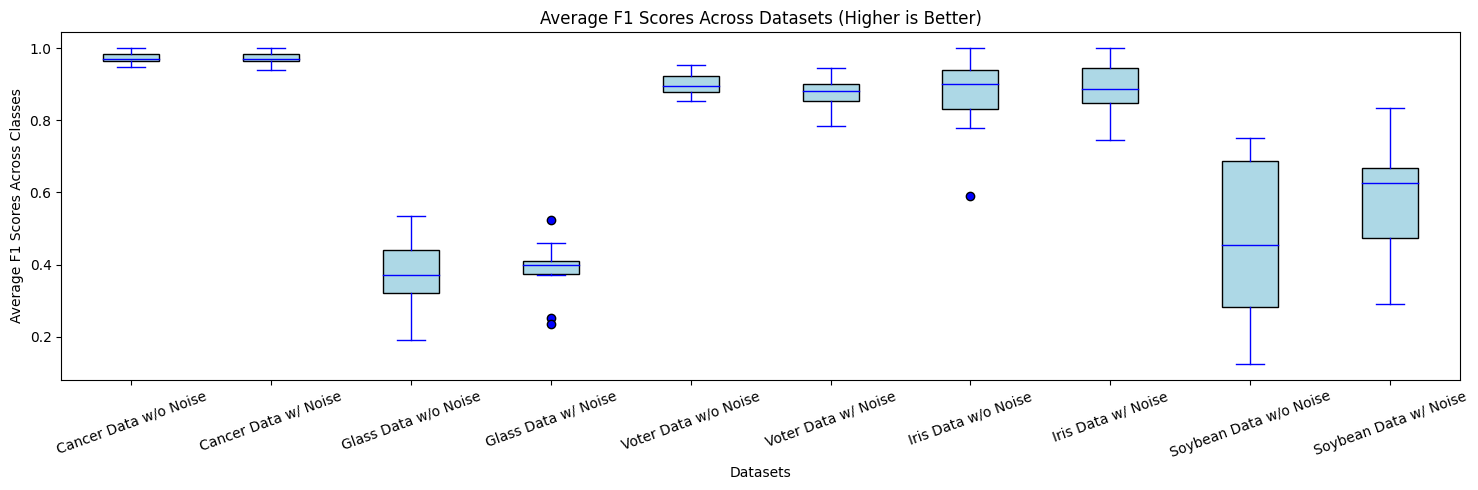

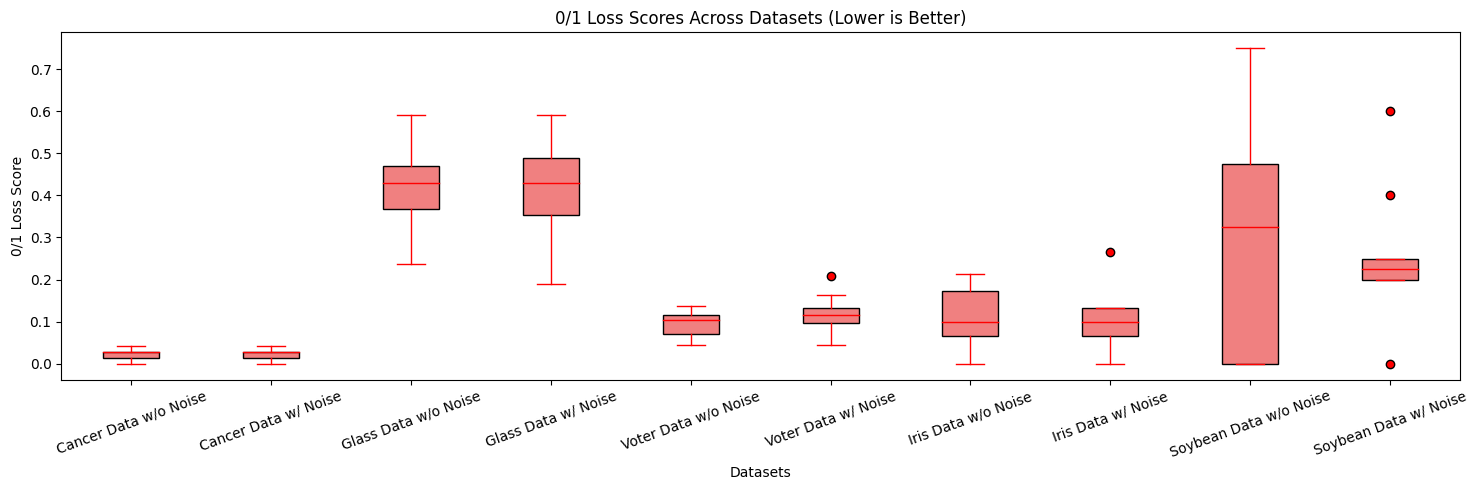

In [569]:
zero_one_list = [cancer_nopre_processing.zero_one_losses, cancer_pre_processing.zero_one_losses, glass_nopre_processing.zero_one_losses, glass_pre_processing.zero_one_losses, votes_nopre_processing.zero_one_losses, votes_pre_processing.zero_one_losses, iris_nopre_processing.zero_one_losses, iris_pre_processing.zero_one_losses, soybean_nopre_processing.zero_one_losses, soybean_pre_processing.zero_one_losses]
f1_scores_list = [cancer_nopre_processing.f1_scores, cancer_pre_processing.f1_scores, glass_nopre_processing.f1_scores, glass_pre_processing.f1_scores, votes_nopre_processing.f1_scores, votes_pre_processing.f1_scores, iris_nopre_processing.f1_scores, iris_pre_processing.f1_scores, soybean_nopre_processing.f1_scores, soybean_pre_processing.f1_scores]
names_list = ['Cancer Data w/o Noise','Cancer Data w/ Noise','Glass Data w/o Noise','Glass Data w/ Noise','Voter Data w/o Noise','Voter Data w/ Noise','Iris Data w/o Noise','Iris Data w/ Noise','Soybean Data w/o Noise','Soybean Data w/ Noise']
# 15,5
figure_size = (15,5)
make_plots(f1_scores_list, zero_one_list, names_list, figure_size, 20)

In [570]:

#print('\n\n\n\n')


#print(f"{glass_nopre_processing.feature_counts['1']}")
#print(f"Feature Counts Dict: {glass_nopre_processing.feature_counts}")

'''
# Access the dictionary for the first dimension '1'
sub_dict = soybean_nopre_processing.feature_counts[]
print(soybean_nopre_processing.feature_counts['D1'])

# Sum the values where the second element of the tuple is '1'
total_sum = sum(value for key, value in sub_dict.items() if key[1] == '1')

print(f"Total sum where the first dimension is 'D1' and tuple dimension is (i, '1'): {total_sum}")
'''
'''
value = 0
sum = 0
for attributes in glass_nopre_processing.feature_counts['1']:
    print(attributes)
    for i in range(10):
        print()
        value = glass_nopre_processing.feature_counts['1'][(i, '1')]
        sum += value

print(f"LOOOK HERE: {sum}")
'''
#print(f"{glass_nopre_processing.feature_counts}")
#print(f"{sum(glass_nopre_processing.feature_counts['1'].values())}")
#print(f"{glass_nopre_processing.class_counts['1'] * 6}")

'''
nopre_answers = []
pre_answers = []
for i in range(10):
    nopre_answers.append([])
    pre_answers.append([])
    for j in range(len(glass_pre_processing.data_array[i])):
        nopre_answers[i].append(glass_nopre_processing.data_array[i][j][-1])
        pre_answers[i].append(glass_pre_processing.data_array[i][j][-1])
#print(f"Class Probs: {soybean_nopre_processing.class_priors}")
#print(f"Feature Pro: {soybean_nopre_processing.feature_probs}")
print(f"w/o Noise Predictions: {glass_nopre_processing.predictions[0]}")
print(f"Answers:               {nopre_answers[0]}    Average F1 Score: {round(glass_nopre_processing.f1_scores[0],3)}    0/1 Loss: {round(glass_nopre_processing.zero_one_losses[0],3)}")
print()
print(f"w/ Noise Predictions:  {glass_pre_processing.predictions[0]}")
print(f"Answers:               {pre_answers[0]}    Average F1 Score: {round(glass_pre_processing.f1_scores[0],3)}    0/1 Loss: {round(glass_pre_processing.zero_one_losses[0],3)}")
'''

'\nnopre_answers = []\npre_answers = []\nfor i in range(10):\n    nopre_answers.append([])\n    pre_answers.append([])\n    for j in range(len(glass_pre_processing.data_array[i])):\n        nopre_answers[i].append(glass_nopre_processing.data_array[i][j][-1])\n        pre_answers[i].append(glass_pre_processing.data_array[i][j][-1])\n#print(f"Class Probs: {soybean_nopre_processing.class_priors}")\n#print(f"Feature Pro: {soybean_nopre_processing.feature_probs}")\nprint(f"w/o Noise Predictions: {glass_nopre_processing.predictions[0]}")\nprint(f"Answers:               {nopre_answers[0]}    Average F1 Score: {round(glass_nopre_processing.f1_scores[0],3)}    0/1 Loss: {round(glass_nopre_processing.zero_one_losses[0],3)}")\nprint()\nprint(f"w/ Noise Predictions:  {glass_pre_processing.predictions[0]}")\nprint(f"Answers:               {pre_answers[0]}    Average F1 Score: {round(glass_pre_processing.f1_scores[0],3)}    0/1 Loss: {round(glass_pre_processing.zero_one_losses[0],3)}")\n'